# MM2 Data Analysis - MOD Incidence + Characteristics

## Data Collection Form

<img src="assets/MOD1.png"/>

<img src="assets/MOD2.png"/>

## Imports

In [1]:
import math
import numpy as np
import pandas as pd

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from datetime import datetime, timedelta
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

## Parameters

## Input

In [3]:
crc_df = pd.read_csv('Data/mm2_crc_merged.csv', engine='python')
crc_df['StudyID'] = crc_df['ï»¿StudyID']
crc_df = crc_df.drop('ï»¿StudyID', axis=1)

In [4]:
lca_df = pd.read_csv('Data/mm2_lca_merged.csv', engine='python')
lca_df['StudyID'] = lca_df['ï»¿StudyID']
lca_df = lca_df.drop('ï»¿StudyID', axis=1)

## Processing

In [5]:
# true EPs are ones where reviewer says it is unplanned, is really first time cancer dx, and there is a cancer signal
def is_true_EP (row):
    if (row['UnplanVal'] == 'Yes' and row['DxVal'] == 'Yes' and not pd.isnull(row['RelSig'])):
        return 1
    else:
        return 0

In [6]:
# true EPs are ones where reviewer says it is unplanned, is really first time cancer dx, and there is a cancer signal
def is_true_EP (row):
    if (row['UnplanVal'] == 'Yes' and row['DxVal'] == 'Yes' and not pd.isnull(row['RelSig'])):
        return 1
    else:
        return 0

In [7]:
def response_num_to_text (row):
    if (row['RelRespNumerical'] == 1):
        return 'No signal requiring f/u'
    elif (row['RelRespNumerical'] == 2):
        return 'Signal not recognized'
    elif (row['RelRespNumerical'] == 3):
        return 'Signal recognized, f/u not initiated'
    elif (row['RelRespNumerical'] == 4):
        return 'Signal recognized, OP f/u'
    elif (row['RelRespNumerical'] == 5):
        return 'Signal recognized, IP f/u'
    elif (row['RelRespNumerical'] == 6):
        return 'Other'
    #else:
        #return 'ERROR'

In [8]:
def typeep_num_to_text (row):
    if (row['TypeOfEP'] == 1):
        return 'Dx within emergency event'
    elif (row['TypeOfEP'] == 2):
        return 'Cancer-related emergency → Related subsequent encounter'
    elif (row['TypeOfEP'] == 3):
        return 'Non-cancer-related emergency → Related subsequent encounter'
    elif (row['TypeOfEP'] == 4):
        return 'Non-cancer-related emergency → Unrelated subsequent encounter'
    elif (row['TypeOfEP'] == 5):
        return 'Other'
    #else:
        #return 'ERROR'

In [9]:
def parse_datetime1 (row, col):
    try:
        return datetime.strptime(row[col], '%m/%d/%Y')
    except:
        return None

In [10]:
def parse_datetime2 (row, col):
    try:
        return datetime.strptime(str(row[col]), '%Y-%m-%d')
    except:
        return None

In [11]:
def is_timedelta_within_threshold (row, col_later, col_earlier, threshold):
    try:
        delta = (row[col_later] - row[col_earlier]).days
        if delta <= threshold:
            return 1
        else:
            return 0
    except:
        return -1

In [12]:
def parse_yesno_1 (row, col):
    if (row[col] == 'Yes'):
        return 1
    else:
        return 0

In [13]:
def parse_01_1 (row, col):
    if (row[col] == 1):
        return 1
    else:
        return 0

In [14]:
def check_not_null (row, col):
    if not pd.isnull(row[col]):
        return 1
    else:
        return 0

In [15]:
# make columns for each individual signal for CRC
def get_crc_sig_01 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RelSig']) and not '10' in str(row['RelSig']) and not '11' in str(row['RelSig']) and not '12' in str(row['RelSig']) and not '13' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_02 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('2' in str(x) and not '12' in str(x)):
                return 1
        return 0
    else:
        if ('2' in str(row['RelSig']) and not '12' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_03 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('3' in str(x) and not '13' in str(x)):
                return 1
        return 0
    else:
        if ('3' in str(row['RelSig']) and not '13' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_04 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('4' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('4' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_05 (row):
    if ('5' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_06 (row):
    if ('6' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_07 (row):
    if ('7' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_08 (row):
    if ('8' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_09 (row):
    if ('9' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_10 (row):
    if ('10' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_11 (row):
    if ('11' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_12 (row):
    if ('12' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_13 (row):
    if ('13' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_14 (row):
    if ('14' in str(row['RelSig'])):
        return 1
    else:
        return 0

In [16]:
# make columns for each individual signal for LCa
def get_lca_sig_01 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RelSig']) and not '10' in str(row['RelSig']) and not '11' in str(row['RelSig']) and not '12' in str(row['RelSig']) and not '13' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_lca_sig_02 (row):
    if ('2' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_03 (row):
    if ('3' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_04 (row):
    if ('4' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_05 (row):
    if ('5' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_06 (row):
    if ('6' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_07 (row):
    if ('7' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_08 (row):
    if ('8' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_09 (row):
    if ('9' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_10 (row):
    if ('10' in str(row['RelSig'])):
        return 1
    else:
        return 0

In [17]:
# make columns for each individual RF for CRC
def get_crc_redf_01 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RFInitialRF']) and not '10' in str(row['RFInitialRF']) and not '11' in str(row['RFInitialRF']) and not '12' in str(row['RFInitialRF']) and not '13' in str(row['RFInitialRF']) and not '14' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_crc_redf_02 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('2' in str(x) and not '12' in str(x)):
                return 1
        return 0
    else:
        if ('2' in str(row['RFInitialRF']) and not '12' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_crc_redf_03 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('3' in str(x) and not '13' in str(x)):
                return 1
        return 0
    else:
        if ('3' in str(row['RFInitialRF']) and not '13' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_crc_redf_04 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('4' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('4' in str(row['RFInitialRF']) and not '14' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_crc_redf_05 (row):
    if ('5' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_06 (row):
    if ('6' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_07 (row):
    if ('7' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_08 (row):
    if ('8' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_09 (row):
    if ('9' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_10 (row):
    if ('10' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_11 (row):
    if ('11' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_12 (row):
    if ('12' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_13 (row):
    if ('13' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_14 (row):
    if ('14' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0

In [18]:
# make columns for each individual signal for LCa
def get_lca_redf_01 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RFInitialRF']) and not '10' in str(row['RFInitialRF']) and not '11' in str(row['RFInitialRF']) and not '12' in str(row['RFInitialRF']) and not '13' in str(row['RFInitialRF']) and not '14' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_lca_redf_02 (row):
    if ('2' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_03 (row):
    if ('3' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_04 (row):
    if ('4' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_05 (row):
    if ('5' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_06 (row):
    if ('6' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_07 (row):
    if ('7' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_08 (row):
    if ('8' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_09 (row):
    if ('9' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_10 (row):
    if ('10' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0

In [19]:
def get_column_stats(col, mean_col, df):
    df_stats = df[col].agg(['mean', 'std', 'count'])
    
    df_stats['ci95_hi'] = (df_stats['mean'] + 1.96 * df_stats['std']/math.sqrt(df_stats['count'])) * 100
    df_stats['ci95_lo'] = (df_stats['mean'] - 1.96 * df_stats['std']/math.sqrt(df_stats['count'])) * 100
    df_stats[mean_col] = df_stats['mean'] * 100
    
    return df_stats

### Apply

In [20]:
crc_df['TrueEP'] = crc_df.apply(lambda row: is_true_EP(row), axis=1)
lca_df['TrueEP'] = lca_df.apply(lambda row: is_true_EP(row), axis=1)

In [21]:
crc_df['ResponseText'] = crc_df.apply(lambda row: response_num_to_text(row), axis=1)
crc_df['ResponseText'] = pd.Categorical(crc_df['ResponseText'], categories=['No signal requiring f/u', 'Signal not recognized', 'Signal recognized, f/u not initiated', 'Signal recognized, OP f/u', 'Signal recognized, IP f/u', 'Other'], ordered=True)
lca_df['ResponseText'] = lca_df.apply(lambda row: response_num_to_text(row), axis=1)
lca_df['ResponseText'] = pd.Categorical(lca_df['ResponseText'], categories=['No signal requiring f/u', 'Signal not recognized', 'Signal recognized, f/u not initiated', 'Signal recognized, OP f/u', 'Signal recognized, IP f/u', 'Other'], ordered=True)

In [22]:
crc_df['TypeEPText'] = crc_df.apply(lambda row: typeep_num_to_text(row), axis=1)
crc_df['TypeEPText'] = pd.Categorical(crc_df['TypeEPText'], categories=['Dx within emergency event', 'Cancer-related emergency → Related subsequent encounter', 'Non-cancer-related emergency → Related subsequent encounter', 'Non-cancer-related emergency → Unrelated subsequent encounter', 'Other'], ordered=True)
lca_df['TypeEPText'] = lca_df.apply(lambda row: typeep_num_to_text(row), axis=1)
lca_df['TypeEPText'] = pd.Categorical(lca_df['TypeEPText'], categories=['Dx within emergency event', 'Cancer-related emergency → Related subsequent encounter', 'Non-cancer-related emergency → Related subsequent encounter', 'Non-cancer-related emergency → Unrelated subsequent encounter', 'Other'], ordered=True)

In [23]:
crc_df['ScreeningTestDateTime'] = crc_df.apply(lambda row: parse_datetime1(row, 'DiagnosticTestDate'), axis=1)
lca_df['ScreeningTestDateTime'] = lca_df.apply(lambda row: parse_datetime2(row, 'DiagnosticTestDate'), axis=1)
crc_df['DiagnosisDateTime'] = crc_df.apply(lambda row: parse_datetime2(row, 'DiagnosticEventDateTime'), axis=1)
lca_df['DiagnosisDateTime'] = lca_df.apply(lambda row: parse_datetime2(row, 'DiagnosticEventDateTime'), axis=1)

crc_df['ScreeningUpToDate'] = crc_df.apply(lambda row: is_timedelta_within_threshold(row, 'DiagnosisDateTime', 'ScreeningTestDateTime', 3650), axis=1)
lca_df['ScreeningUpToDate'] = lca_df.apply(lambda row: is_timedelta_within_threshold(row, 'DiagnosisDateTime', 'ScreeningTestDateTime', 3650), axis=1)

In [24]:
crc_df['RFPriorToDx'] = crc_df.apply(lambda row: parse_yesno_1(row, 'RFYesNo'), axis=1)
# lung cancer is already in 1 0 format
lca_df['RFPriorToDx'] = lca_df.apply(lambda row: parse_01_1(row, 'RFYesNo'), axis=1)

In [25]:
crc_df['HasMOD'] = crc_df.apply(lambda row: parse_yesno_1(row, 'DxMOD'), axis=1)
# lung cancer is already in 1 0 format
lca_df['HasMOD'] = lca_df.apply(lambda row: parse_01_1(row, 'DxMOD'), axis=1)

In [26]:
crc_df['DimensionPtRelated_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionPtRelated'), axis=1)
crc_df['DimensionPtProvEncounter_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionPtProvEncounter'), axis=1)
crc_df['DimensionDxTests_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionDxTests'), axis=1)
crc_df['DimensionFupTrack_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionFupTrack'), axis=1)
crc_df['DimensionReferrals_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionReferrals'), axis=1)

lca_df['DimensionPtRelated_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionPtRelated'), axis=1)
lca_df['DimensionPtProvEncounter_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionPtProvEncounter'), axis=1)
lca_df['DimensionDxTests_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionDxTests'), axis=1)
lca_df['DimensionFupTrack_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionFupTrack'), axis=1)
lca_df['DimensionReferrals_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionReferrals'), axis=1)

In [27]:
crc_df['Signal_IDA'] = crc_df.apply(lambda row: get_crc_sig_01(row), axis=1)
crc_df['Signal_Obstruction'] = crc_df.apply(lambda row: get_crc_sig_02(row), axis=1)
crc_df['Signal_BloodyStool'] = crc_df.apply(lambda row: get_crc_sig_03(row), axis=1)
crc_df['Signal_AbdMass'] = crc_df.apply(lambda row: get_crc_sig_04(row), axis=1)
crc_df['Signal_RectMass'] = crc_df.apply(lambda row: get_crc_sig_05(row), axis=1)
crc_df['Signal_StoolCaliber'] = crc_df.apply(lambda row: get_crc_sig_06(row), axis=1)
crc_df['Signal_CScope'] = crc_df.apply(lambda row: get_crc_sig_07(row), axis=1)
crc_df['Signal_FOBT'] = crc_df.apply(lambda row: get_crc_sig_08(row), axis=1)
crc_df['Signal_FlexSig'] = crc_df.apply(lambda row: get_crc_sig_09(row), axis=1)
crc_df['Signal_Enema'] = crc_df.apply(lambda row: get_crc_sig_10(row), axis=1)
crc_df['Signal_CT'] = crc_df.apply(lambda row: get_crc_sig_11(row), axis=1)
crc_df['Signal_FamHx'] = crc_df.apply(lambda row: get_crc_sig_12(row), axis=1)
crc_df['Signal_MassExam'] = crc_df.apply(lambda row: get_crc_sig_13(row), axis=1)
crc_df['Signal_Other'] = crc_df.apply(lambda row: get_crc_sig_14(row), axis=1)

In [28]:
lca_df['Signal_Cough'] = lca_df.apply(lambda row: get_lca_sig_01(row), axis=1)
lca_df['Signal_Dyspnea'] = lca_df.apply(lambda row: get_lca_sig_02(row), axis=1)
lca_df['Signal_ChestPain'] = lca_df.apply(lambda row: get_lca_sig_03(row), axis=1)
lca_df['Signal_Hemoptysis'] = lca_df.apply(lambda row: get_lca_sig_04(row), axis=1)
lca_df['Signal_LRTI'] = lca_df.apply(lambda row: get_lca_sig_05(row), axis=1)
lca_df['Signal_Imaging'] = lca_df.apply(lambda row: get_lca_sig_06(row), axis=1)
lca_df['Signal_Paraneoplastic'] = lca_df.apply(lambda row: get_lca_sig_07(row), axis=1)
lca_df['Signal_Hoarse'] = lca_df.apply(lambda row: get_lca_sig_08(row), axis=1)
lca_df['Signal_WtLoss'] = lca_df.apply(lambda row: get_lca_sig_09(row), axis=1)
lca_df['Signal_Other'] = lca_df.apply(lambda row: get_lca_sig_10(row), axis=1)

In [29]:
crc_df['Redf_IDA'] = crc_df.apply(lambda row: get_crc_redf_01(row), axis=1)
crc_df['Redf_Obstruction'] = crc_df.apply(lambda row: get_crc_redf_02(row), axis=1)
crc_df['Redf_BloodyStool'] = crc_df.apply(lambda row: get_crc_redf_03(row), axis=1)
crc_df['Redf_AbdMass'] = crc_df.apply(lambda row: get_crc_redf_04(row), axis=1)
crc_df['Redf_RectMass'] = crc_df.apply(lambda row: get_crc_redf_05(row), axis=1)
crc_df['Redf_StoolCaliber'] = crc_df.apply(lambda row: get_crc_redf_06(row), axis=1)
crc_df['Redf_CScope'] = crc_df.apply(lambda row: get_crc_redf_07(row), axis=1)
crc_df['Redf_FOBT'] = crc_df.apply(lambda row: get_crc_redf_08(row), axis=1)
crc_df['Redf_FlexSig'] = crc_df.apply(lambda row: get_crc_redf_09(row), axis=1)
crc_df['Redf_Enema'] = crc_df.apply(lambda row: get_crc_redf_10(row), axis=1)
crc_df['Redf_CT'] = crc_df.apply(lambda row: get_crc_redf_11(row), axis=1)
crc_df['Redf_FamHx'] = crc_df.apply(lambda row: get_crc_redf_12(row), axis=1)
crc_df['Redf_MassExam'] = crc_df.apply(lambda row: get_crc_redf_13(row), axis=1)
crc_df['Redf_Other'] = crc_df.apply(lambda row: get_crc_redf_14(row), axis=1)

In [30]:
lca_df['Redf_Cough'] = lca_df.apply(lambda row: get_lca_redf_01(row), axis=1)
lca_df['Redf_Dyspnea'] = lca_df.apply(lambda row: get_lca_redf_02(row), axis=1)
lca_df['Redf_ChestPain'] = lca_df.apply(lambda row: get_lca_redf_03(row), axis=1)
lca_df['Redf_Hemoptysis'] = lca_df.apply(lambda row: get_lca_redf_04(row), axis=1)
lca_df['Redf_LRTI'] = lca_df.apply(lambda row: get_lca_redf_05(row), axis=1)
lca_df['Redf_Imaging'] = lca_df.apply(lambda row: get_lca_redf_06(row), axis=1)
lca_df['Redf_Paraneoplastic'] = lca_df.apply(lambda row: get_lca_redf_07(row), axis=1)
lca_df['Redf_Hoarse'] = lca_df.apply(lambda row: get_lca_redf_08(row), axis=1)
lca_df['Redf_WtLoss'] = lca_df.apply(lambda row: get_lca_redf_09(row), axis=1)
lca_df['Redf_Other'] = lca_df.apply(lambda row: get_lca_redf_10(row), axis=1)

In [31]:
lca_dim_master = pd.DataFrame(columns=['Dimension', 'True EP', 'True MOD', 'PatientSSN'])

for x in lca_df.index:
    if lca_df.loc[x]['DimensionPtRelated_Parsed'] == 1:
        lca_dim_master.loc[len(lca_dim_master.index)] = ['Patient-Related', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD'], lca_df.loc[x]['PatientSSN']]
    if lca_df.loc[x]['DimensionPtProvEncounter_Parsed'] == 1:
        lca_dim_master.loc[len(lca_dim_master.index)] = ['Patient-Provider Encounter', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD'], lca_df.loc[x]['PatientSSN']]
    if lca_df.loc[x]['DimensionDxTests_Parsed'] == 1:
        lca_dim_master.loc[len(lca_dim_master.index)] = ['Diagnostic Testing', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD'], lca_df.loc[x]['PatientSSN']]
    if lca_df.loc[x]['DimensionFupTrack_Parsed'] == 1:
        lca_dim_master.loc[len(lca_dim_master.index)] = ['Follow-Up and Tracking', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD'], lca_df.loc[x]['PatientSSN']]
    if lca_df.loc[x]['DimensionReferrals_Parsed'] == 1:
        lca_dim_master.loc[len(lca_dim_master.index)] = ['Referrals', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD'], lca_df.loc[x]['PatientSSN']]

In [32]:
crc_dim_master = pd.DataFrame(columns=['Dimension', 'True EP', 'True MOD', 'PatientSSN'])

for x in crc_df.index:
    if crc_df.loc[x]['DimensionPtRelated_Parsed'] == 1:
        crc_dim_master.loc[len(crc_dim_master.index)] = ['Patient-Related', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD'], crc_df.loc[x]['PatientSSN']]
    if crc_df.loc[x]['DimensionPtProvEncounter_Parsed'] == 1:
        crc_dim_master.loc[len(crc_dim_master.index)] = ['Patient-Provider Encounter', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD'], crc_df.loc[x]['PatientSSN']]
    if crc_df.loc[x]['DimensionDxTests_Parsed'] == 1:
        crc_dim_master.loc[len(crc_dim_master.index)] = ['Diagnostic Testing', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD'], crc_df.loc[x]['PatientSSN']]
    if crc_df.loc[x]['DimensionFupTrack_Parsed'] == 1:
        crc_dim_master.loc[len(crc_dim_master.index)] = ['Follow-Up and Tracking', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD'], crc_df.loc[x]['PatientSSN']]
    if crc_df.loc[x]['DimensionReferrals_Parsed'] == 1:
        crc_dim_master.loc[len(crc_dim_master.index)] = ['Referrals', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD'], crc_df.loc[x]['PatientSSN']]

In [33]:
lca_dim_master['Cancer'] = 'Lung'
crc_dim_master['Cancer'] = 'Colorectal'

both_dim_master = pd.concat([crc_dim_master, lca_dim_master], axis=0).reset_index()

In [34]:
lca_sig_master = pd.DataFrame(columns=['Signal', 'True EP', 'True MOD'])

for x in lca_df.index:
    if lca_df.loc[x]['Signal_Cough'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Cough', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Dyspnea'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Dyspnea', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_ChestPain'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Chest Pain', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Hemoptysis'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Hemoptysis', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_LRTI'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['LRTI', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Imaging'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Imaging', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Paraneoplastic'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Hoarse', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Hoarse'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Hoarse', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_WtLoss'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Weight Loss', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Other'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Other', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Cough'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Cough', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    

In [35]:
crc_sig_master = pd.DataFrame(columns=['Signal', 'True EP', 'True MOD'])

for x in crc_df.index:
    if crc_df.loc[x]['Signal_IDA'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['IDA', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_Obstruction'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Obstruction', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_BloodyStool'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Bloody Stool', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_AbdMass'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Abdominal Mass', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_RectMass'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Rectal Mass', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_StoolCaliber'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Stool Caliber', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_CScope'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Colonoscopy', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_FOBT'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['FOBT', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_FlexSig'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Flexible Sigmoidoscopy', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_Enema'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Barium Enema', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_CT'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['CT Finding', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_FamHx'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Family History', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_MassExam'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Mass on Examination', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_Other'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Other', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]

In [36]:
lca_redf_master = pd.DataFrame(columns=['Red Flag', 'True EP', 'True MOD'])

for x in lca_df.index:
    if lca_df.loc[x]['Redf_Cough'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Cough', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_Dyspnea'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Dyspnea', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_ChestPain'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Chest Pain', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_Hemoptysis'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Hemoptysis', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_LRTI'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['LRTI', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_Imaging'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Imaging', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_Paraneoplastic'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Hoarse', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_Hoarse'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Hoarse', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_WtLoss'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Weight Loss', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_Other'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Other', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Redf_Cough'] == 1:
        lca_redf_master.loc[len(lca_redf_master.index)] = ['Cough', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]

In [37]:
crc_redf_master = pd.DataFrame(columns=['Red Flag', 'True EP', 'True MOD'])

for x in crc_df.index:
    if crc_df.loc[x]['Redf_IDA'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['IDA', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_Obstruction'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Obstruction', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_BloodyStool'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Bloody Stool', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_AbdMass'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Abdominal Mass', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_RectMass'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Rectal Mass', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_StoolCaliber'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Stool Caliber', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_CScope'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Colonoscopy', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_FOBT'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['FOBT', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_FlexSig'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Flexible Sigmoidoscopy', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_Enema'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Barium Enema', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_CT'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['CT Finding', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_FamHx'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Family History', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_MassExam'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Mass on Examination', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Redf_Other'] == 1:
        crc_redf_master.loc[len(crc_redf_master.index)] = ['Other', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]

## Descriptive Stats

### True EP Rate

#### Lung Cancer

In [38]:
lca_tep_stats = get_column_stats('TrueEP', '% True EP', lca_df)
lca_tep_stats

mean           0.800000
std            0.402015
count        100.000000
ci95_hi       87.879496
ci95_lo       72.120504
% True EP     80.000000
Name: TrueEP, dtype: float64

#### CRC

In [39]:
crc_tep_stats = get_column_stats('TrueEP', '% True EP', crc_df)
crc_tep_stats

mean           0.730000
std            0.446196
count        100.000000
ci95_hi       81.745442
ci95_lo       64.254558
% True EP     73.000000
Name: TrueEP, dtype: float64

### Up to date on screening

#### CRC

In [40]:
crc_scr_stats = get_column_stats('ScreeningUpToDate', '% Up To Date on Screening', crc_df[crc_df['TrueEP'] == 1].copy())
crc_scr_stats

mean                          0.232877
std                           0.425589
count                        73.000000
ci95_hi                      33.050720
ci95_lo                      13.524623
% Up To Date on Screening    23.287671
Name: ScreeningUpToDate, dtype: float64

#### LCa

In [41]:
lca_scr_stats = get_column_stats('ScreeningUpToDate', '% Up To Date on Screening', lca_df[lca_df['TrueEP'] == 1].copy())
lca_scr_stats

mean                          0.137500
std                           0.346547
count                        80.000000
ci95_hi                      21.344050
ci95_lo                       6.155950
% Up To Date on Screening    13.750000
Name: ScreeningUpToDate, dtype: float64

### Earliest Red Flag → Multiple Red Flags → Follow-Up? → Time to follow-up

#### LCa

In [42]:
lca_df[pd.notnull(lca_df['RFInitialRF'])].shape[0]

43

In [43]:
lca_redf_df = pd.DataFrame({'Signal':['Cough', 'Dyspnea', 'ChestPain', 'Hemoptysis', 'LRTI', 'Imaging', 'Paraneoplastic', 'Hoarse', 'WtLoss', 'Other']})
lca_redf_vals = [] 

lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_Cough'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_Dyspnea'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_ChestPain'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_Hemoptysis'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_LRTI'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_Imaging'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_Paraneoplastic'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_Hoarse'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_WtLoss'].agg('mean') * 100)
lca_redf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Redf_Other'].agg('mean') * 100)

lca_redf_df['Frequency'] = lca_redf_vals
lca_redf_df = lca_redf_df.sort_values(by='Frequency', ascending=False)

In [44]:
lca_redf_df

,Signal,Frequency
5,Imaging,16.25
0,Cough,13.75
4,LRTI,7.50
1,Dyspnea,5.00
2,ChestPain,2.50
8,WtLoss,2.50
3,Hemoptysis,0.00
6,Paraneoplastic,0.00
7,Hoarse,0.00
9,Other,0.00


(0.0, 1.0)

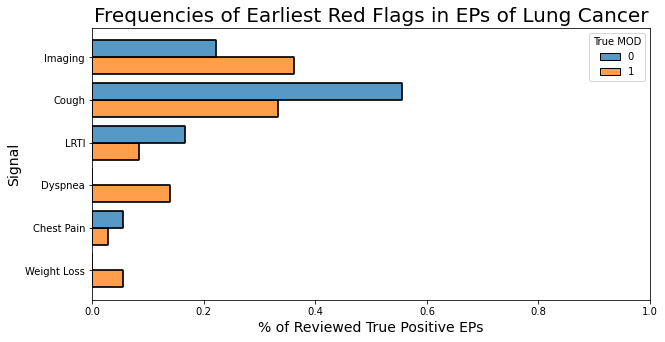

In [45]:
lca_redf_plt = sns.histplot(data=lca_redf_master, y='Red Flag', hue='True MOD', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
lca_redf_plt.axes.set_title("Frequencies of Earliest Red Flags in EPs of Lung Cancer", fontsize=20)
lca_redf_plt.axes.set_ylabel ("Signal", fontsize=14)
lca_redf_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
lca_redf_plt.axes.set_xlim ([0, 1])

#### CRC

In [46]:
crc_df[pd.notnull(crc_df['RFInitialRF'])].shape[0]

52

In [47]:
crc_redf_df = pd.DataFrame({'Signal':['IDA', 'Obstruction', 'BloodyStool', 'AbdMass', 'RectMass', 'StoolCaliber', 'CScope', 'FOBT', 'FlexSig', 'Enema', 'CT', 'FamHx', 'MassExam', 'Other']})
crc_redf_vals = [] 

crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_IDA'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_Obstruction'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_BloodyStool'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_AbdMass'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_RectMass'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_StoolCaliber'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_CScope'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_FOBT'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_FlexSig'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_Enema'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_CT'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_FamHx'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_MassExam'].agg('mean') * 100)
crc_redf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Redf_Other'].agg('mean') * 100)

crc_redf_df['Frequency'] = crc_redf_vals
crc_redf_df = crc_redf_df.sort_values(by='Frequency', ascending=False)

In [48]:
crc_redf_df

,Signal,Frequency
0,IDA,43.835616
2,BloodyStool,10.958904
7,FOBT,4.109589
3,AbdMass,1.369863
4,RectMass,1.369863
6,CScope,1.369863
10,CT,1.369863
13,Other,1.369863
1,Obstruction,0.000000
5,StoolCaliber,0.000000


(0.0, 1.0)

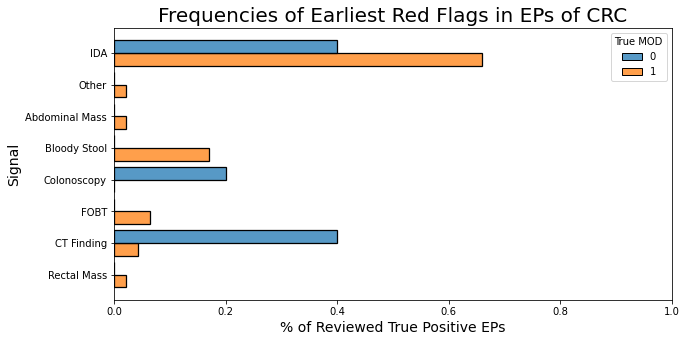

In [49]:
crc_redf_plt = sns.histplot(data=crc_redf_master, y='Red Flag', hue='True MOD', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
crc_redf_plt.axes.set_title("Frequencies of Earliest Red Flags in EPs of CRC", fontsize=20)
crc_redf_plt.axes.set_ylabel ("Signal", fontsize=14)
crc_redf_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
crc_redf_plt.axes.set_xlim ([0, 1])

#### LCa

In [50]:
lca_rf_stats = lca_df[lca_df['TrueEP'] == 1]['RFPriorToDx'].agg(['mean'])
lca_rf_stats["% RF prior to Dx"] = lca_rf_stats['mean'] * 100
lca_rf_stats['% RF prior to Dx']

47.5

#### CRC

In [51]:
crc_rf_stats = crc_df[crc_df['TrueEP'] == 1]['RFPriorToDx'].agg(['mean'])
crc_rf_stats["% RF prior to Dx"] = crc_rf_stats['mean'] * 100
crc_rf_stats['% RF prior to Dx']

65.75342465753424

### MOD (Screening, Type I, Type II)

#### LCa

In [53]:
lca_mod_stats = lca_df[lca_df['TrueEP'] == 1]['HasMOD'].agg(['mean'])
lca_mod_stats['% MODs'] = lca_mod_stats['mean'] * 100
lca_mod_stats['% MODs']

47.5

In [77]:
lca_df[lca_df['HasMOD'] == 1].shape[0]

43

In [76]:
lca_df[(lca_df['HasMOD'] == 1) & (lca_df['DxDelayRFFUReq'] != 1) & (lca_df['DxDelayRFFUComp'] != 1)].shape[0]

21

In [79]:
lca_df[(lca_df['HasMOD'] == 1) & (lca_df['DxDelayRFFUReq'] == 1) & (lca_df['DxDelayRFFUComp'] != 1)].shape[0]

11

In [80]:
lca_df[(lca_df['HasMOD'] == 1) & (lca_df['DxDelayRFFUReq'] != 1) & (lca_df['DxDelayRFFUComp'] == 1)].shape[0]

6

In [82]:
lca_df[(lca_df['HasMOD'] == 1) & (lca_df['DxDelayRFFUReq'] == 1) & (lca_df['DxDelayRFFUComp'] == 1)].shape[0]

5

In [81]:
#lca_df[(lca_df['HasMOD'] == 1)][['HasMOD', 'DxDelayRFFUReq', 'DxDelayRFFUComp']]

In [85]:
lca_df[(lca_df['HasMOD'] == 1) & (lca_df['RFYesNo'] == 1)].shape[0]

30

In [86]:
lca_df[(lca_df['HasMOD'] == 1) & (lca_df['RFYesNo'] == 1) & (lca_df['RFMultYesNo'] == 1)].shape[0]

11

#### CRC

In [87]:
crc_mod_stats = crc_df[crc_df['TrueEP'] == 1]['HasMOD'].agg(['mean'])
crc_mod_stats['% MODs'] = crc_mod_stats['mean'] * 100
crc_mod_stats['% MODs']

69.86301369863014

In [93]:
crc_df[crc_df['HasMOD'] == 1].shape[0]

56

In [99]:
crc_df[(crc_df['HasMOD'] == 1) & (crc_df['DxDelayRFFUReq'] != 'Yes') & (crc_df['DxDelayRFFUComp'] != 'Yes')].shape[0]

14

In [94]:
crc_df[(crc_df['HasMOD'] == 1) & (crc_df['DxDelayRFFUReq'] == 'Yes') & (crc_df['DxDelayRFFUComp'] != 'Yes')].shape[0]

27

In [95]:
crc_df[(lca_df['HasMOD'] == 1) & (crc_df['DxDelayRFFUReq'] != 'Yes') & (crc_df['DxDelayRFFUComp'] == 'Yes')].shape[0]

2

In [96]:
crc_df[(crc_df['HasMOD'] == 1) & (crc_df['DxDelayRFFUReq'] == 'Yes') & (crc_df['DxDelayRFFUComp'] == 'Yes')].shape[0]

9

In [81]:
#lca_df[(lca_df['HasMOD'] == 1)][['HasMOD', 'DxDelayRFFUReq', 'DxDelayRFFUComp']]

In [100]:
crc_df[(crc_df['HasMOD'] == 1) & (crc_df['RFYesNo'] == 'Yes')].shape[0]

47

In [101]:
crc_df[(crc_df['HasMOD'] == 1) & (crc_df['RFYesNo'] == 'Yes') & (crc_df['RFMultYesNo'] == 'Yes')].shape[0]

15

### MOD Dimensions

#### LCa

In [65]:
lca_dim_df = pd.DataFrame({'Dimension':['Patient-Related', 'Patient-Provider Encounter', 'Diagnostic Tests', 'Follow-Up and Tracking', 'Referrals']})
lca_dim_vals = [] 

lca_dim_vals.append(lca_df[lca_df['HasMOD'] == 1]['DimensionPtRelated_Parsed'].agg('mean') * 100)
lca_dim_vals.append(lca_df[lca_df['HasMOD'] == 1]['DimensionPtProvEncounter_Parsed'].agg('mean') * 100)
lca_dim_vals.append(lca_df[lca_df['HasMOD'] == 1]['DimensionDxTests_Parsed'].agg('mean') * 100)
lca_dim_vals.append(lca_df[lca_df['HasMOD'] == 1]['DimensionFupTrack_Parsed'].agg('mean') * 100)
lca_dim_vals.append(lca_df[lca_df['HasMOD'] == 1]['DimensionReferrals_Parsed'].agg('mean') * 100)

lca_dim_df['Frequency'] = lca_dim_vals

In [66]:
lca_dim_df

,Dimension,Frequency
0,Patient-Related,30.232558
1,Patient-Provider Encounter,30.232558
2,Diagnostic Tests,53.488372
3,Follow-Up and Tracking,20.930233
4,Referrals,0.000000


#### CRC

In [67]:
crc_dim_df = pd.DataFrame({'Dimension':['Patient-Related', 'Patient-Provider Encounter', 'Diagnostic Tests', 'Follow-Up and Tracking', 'Referrals']})
crc_dim_vals = [] 

crc_dim_vals.append(crc_df[crc_df['HasMOD'] == 1]['DimensionPtRelated_Parsed'].agg('mean') * 100)
crc_dim_vals.append(crc_df[crc_df['HasMOD'] == 1]['DimensionPtProvEncounter_Parsed'].agg('mean') * 100)
crc_dim_vals.append(crc_df[crc_df['HasMOD'] == 1]['DimensionDxTests_Parsed'].agg('mean') * 100)
crc_dim_vals.append(crc_df[crc_df['HasMOD'] == 1]['DimensionFupTrack_Parsed'].agg('mean') * 100)
crc_dim_vals.append(crc_df[crc_df['HasMOD'] == 1]['DimensionReferrals_Parsed'].agg('mean') * 100)

crc_dim_df['Frequency'] = crc_dim_vals

In [68]:
crc_dim_df

,Dimension,Frequency
0,Patient-Related,57.142857
1,Patient-Provider Encounter,39.285714
2,Diagnostic Tests,23.214286
3,Follow-Up and Tracking,35.714286
4,Referrals,0.000000


[None, None, None, None]

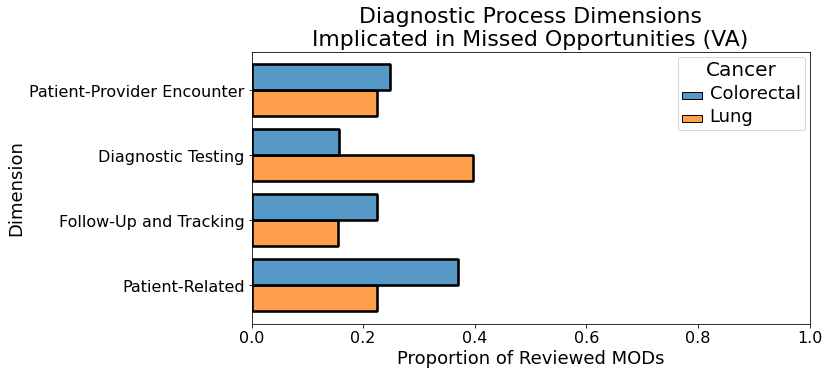

In [69]:
lca_redf_plt = sns.histplot(data=both_dim_master, y='Dimension', hue='Cancer', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
lca_redf_plt.axes.set_title("Diagnostic Process Dimensions\nImplicated in Missed Opportunities (VA)", fontsize=22)
plt.ylabel ("Dimension", fontsize=18)
plt.yticks (fontsize=16)
plt.xlabel ("Proportion of Reviewed MODs", fontsize=18)
plt.xticks (fontsize=16)
plt.xlim ([0, 1])
plt.setp(lca_redf_plt.get_legend().get_title(), fontsize=20)
plt.setp(lca_redf_plt.get_legend().get_texts(), fontsize=18)

In [70]:
both_dim_master.groupby('PatientSSN').agg('count')['Dimension'].value_counts()

1    62
2    28
3     7
4     2
Name: Dimension, dtype: int64

In [71]:
both_dim_master[both_dim_master['Cancer'] == 'Lung'].groupby('PatientSSN').agg('count')['Dimension'].value_counts()

1    31
2     9
3     3
Name: Dimension, dtype: int64

In [72]:
both_dim_master[both_dim_master['Cancer'] == 'Colorectal'].groupby('PatientSSN').agg('count')['Dimension'].value_counts()

1    31
2    19
3     4
4     2
Name: Dimension, dtype: int64